In [697]:
import numpy as np
from numba import jit
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [698]:
# generate a random point
def generate_points(grid, size_x, size_y, num_points, min_distance_btw_points, max_distance_btw_points):

    # generate first random point
    x = random.randint(0, size_x-1)
    y = random.randint(0, size_y-1)
    grid[x, y] = 1

    # generate the rest of the points with a max distance from previous points
    for i in range(num_points-1):
        
        # generate a number between min_distance_btw_points and max_distance_btw_points
        distance_x = random.randint(min_distance_btw_points, max_distance_btw_points)

        # compute max_distance_y
        max_distance_y = np.sqrt(max_distance_btw_points**2 - distance_x**2)

        # ensure max_distance_y is at least min_distance_btw_points
        if max_distance_y < min_distance_btw_points:
            max_distance_y = min_distance_btw_points

        # generate a number between 0 and max_distance_y
        distance_y = random.randint(min_distance_btw_points, int(max_distance_y))

        # generate a random sign
        sign_x = random.choice([-1, 1])
        sign_y = random.choice([-1, 1])

        # generate the new point
        new_x = x + sign_x * distance_x
        new_y = y + sign_y * distance_y

        # if new points are out of the grid, use continues boundaries
        if new_x < 0:
            new_x = size_x + new_x
        if new_x >= size_x:
            new_x = new_x - size_x
        
        if new_y < 0:
            new_y = size_y + new_y
        if new_y >= size_y:
            new_y = new_y - size_y

        # add the new point to the grid
        grid[new_x, new_y] = 1

        # update x and y
        x = new_x
        y = new_y

    return grid

In [706]:
grid = np.zeros([150,300])
# box of generation:
x_lim = 150
y_lim = 300
n_points = 150

min_dis = 4
max_dis = 10

grid_with_points = generate_points(grid, x_lim, y_lim, n_points, min_dis, max_dis)

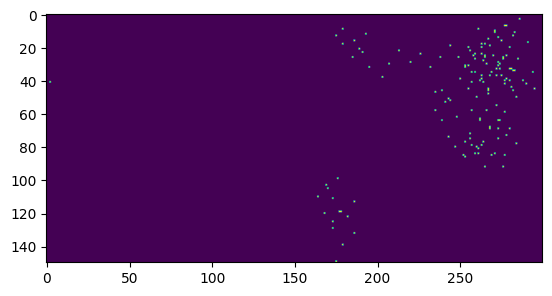

In [707]:
plt.imshow(grid_with_points)

In [708]:
# generate a power law distribution of radii
def generate_radii(n_points, exponent=1.5, min_circle=3):
    u = np.random.uniform(0, 1, size=n_points)  # uniform random values
    radii = min_circle * (1 - u) ** (-1 / (exponent))
    return radii

In [709]:

@jit(nopython=True)  # Just-In-Time compilation for speed
def circle_to_point_with_radii(grid, radii):
    size_x, size_y = grid.shape
    noise_grid = np.zeros((size_x, size_y))
    points = np.argwhere(grid == 1)

    if len(points) == 0:
        return noise_grid

    num_points = len(points)

    # Iterate over each point
    for i in range(num_points):
        px, py = points[i]
        radius_squared = radii[i] ** 2
        
        # Define the bounds for the square region to check
        x_min = max(px - radii[i], 0)
        x_max = min(px + radii[i] + 1, size_x)
        y_min = max(py - radii[i], 0)
        y_max = min(py + radii[i] + 1, size_y)

        # Calculate distances in the bounding box
        for x in range(x_min, x_max):
            for y in range(y_min, y_max):
                dist_squared = (x - px) ** 2 + (y - py) ** 2
                if dist_squared < radius_squared:
                    noise_grid[x, y] += 1

    noise_grid[noise_grid == 1] = 0
    noise_grid[noise_grid == 2] = 0

    # Normalize the grid
    min_val = np.min(noise_grid)
    max_val = np.max(noise_grid)

    if min_val != max_val:  # Prevent division by zero
        noise_grid = (noise_grid - min_val) / (max_val - min_val)

    return noise_grid

In [730]:
@jit(nopython=True)
def circle_to_point_with_radii(grid, radii, sun_x, sun_y):
    size_x, size_y = grid.shape
    noise_grid = np.zeros((size_x, size_y))
    shadow_grid = np.zeros((size_x, size_y))
    mask_grid = np.zeros((size_x, size_y))
    points = np.argwhere(grid == 1)

    if len(points) == 0:
        return noise_grid, shadow_grid, mask_grid

    num_points = len(points)

    # Iterate over each point
    for i in range(num_points):
        px, py = points[i]
        radius_squared = radii[i] ** 2
        
        # Define the bounds for the square region to check
        x_min = max(px - radii[i], 0)
        x_max = min(px + radii[i] + 1, size_x)
        y_min = max(py - radii[i], 0)
        y_max = min(py + radii[i] + 1, size_y)

        # Calculate distances in the bounding box
        for x in range(x_min, x_max):
            for y in range(y_min, y_max):
                dist_squared = (x - px) ** 2 + (y - py) ** 2
                if dist_squared < radius_squared:
                    noise_grid[x, y] += 1  # Increase the value of covered pixels by 1
                    shadow_grid[x, y] = 1
                    shadow_grid[x - sun_x, y - sun_y] = 0
                    mask_grid[x, y] = 1
    
    # Eliminate all pixels with values 1 and 2
    for x in range(size_x):
        for y in range(size_y):
            if noise_grid[x, y] == 1 or noise_grid[x, y] == 2:
                noise_grid[x, y] = 0
                shadow_grid[x, y] = 0
                if noise_grid[x, y] == 3 or noise_grid[x, y] == 4 or noise_grid[x, y] == 5 or noise_grid[x, y] == 6:
                    mask_grid[x, y] = 0

    

    # normalize the grid:
    min_val = np.min(noise_grid)
    max_val = np.max(noise_grid)

    if min_val != max_val:  # Prevent division by zero
        noise_grid = (noise_grid - min_val) / (max_val - min_val)

    return noise_grid, shadow_grid, mask_grid


In [731]:
radii = generate_radii(n_points, exponent=2, min_circle=3)
cloudy_grid, shadow_grid, mask_for_shadow_grid = circle_to_point_with_radii(grid, radii, sun_x=5, sun_y=5)

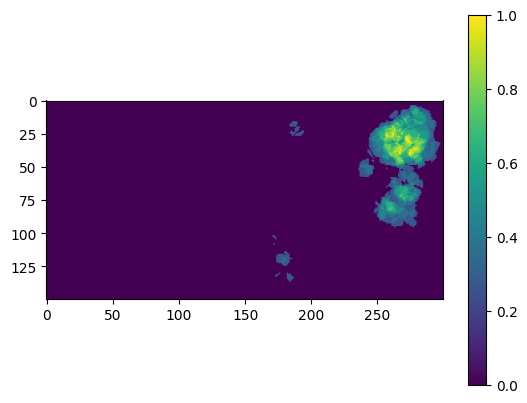

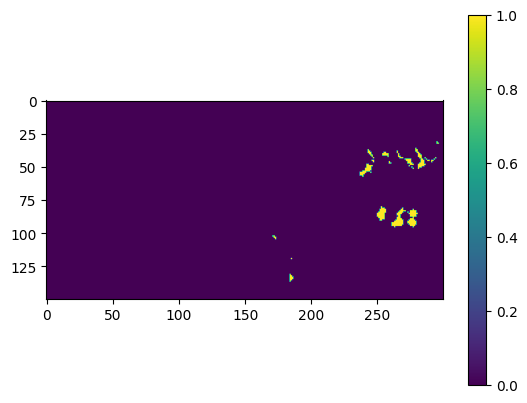

In [732]:
plt.imshow(cloudy_grid)
plt.colorbar()
plt.show()

# apply mask_for_shadow_grid to shadow_grid
shadow_grid = shadow_grid * mask_for_shadow_grid
plt.imshow(shadow_grid)
plt.colorbar()
plt.show()



In [733]:
# Visualization function with a custom colormap
def visualize_grid(grid, my_alpha, k, title=''):
    # Define a custom colormap from light blue to white
    colors = [(0.678, 0.847, 0.902), (1, 1, 1)]  # Light blue to white (RGB values)
    cmap = LinearSegmentedColormap.from_list('custom_blue_white', colors, N=256)

    # Hill equation parameters
    n = my_alpha  # Hill coefficient
    K_d = k # Dissociation constant, you can adjust this value as needed

    # Apply the Hill equation to the grid values
    hill_grid = (np.clip((grid**n) / (K_d**n + grid**n), 0, 1)) * 255

    # Plot the grid with the custom colormap
    plt.imshow(hill_grid, cmap=cmap)

    # Size of the plot
    plt.gcf().set_size_inches(15, 5)

    plt.colorbar(label='Noise Intensity')
    plt.title(title)
    plt.grid(False)  # Optional: hide gridlines for a cleaner look
    plt.xticks([])   # Optional: hide x-axis ticks
    plt.yticks([])   # Optional: hide y-axis ticks
    plt.show()

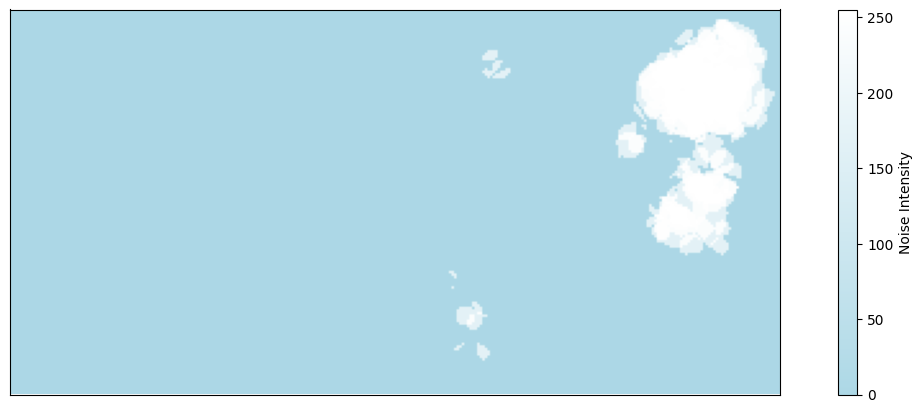

In [734]:
visualize_grid(cloudy_grid, my_alpha = 8, k = 0.25)

In [735]:
from PIL import Image, ImageOps
import numpy as np

# Visualization function using Pillow (clouds, sky, and shadows)
def visualize_clouds_shadows_pillow(cloud_grid, shadow_grid, my_alpha, k, title=''):
    # Hill equation parameters for scaling intensity
    n = my_alpha  # Hill coefficient
    K_d = k       # Dissociation constant
    
    # Apply Hill equation to cloud and shadow grids
    hill_clouds = np.clip((cloud_grid**n) / (K_d**n + cloud_grid**n), 0, 1) * 255
    hill_shadows = np.clip((shadow_grid**n) / (K_d**n + shadow_grid**n), 0, 1) * 255

    # Convert clouds and shadows grids to images (8-bit grayscale)
    clouds_image = Image.fromarray(hill_clouds.astype(np.uint8), mode='L')  # Clouds are white
    shadows_image = Image.fromarray(hill_shadows.astype(np.uint8), mode='L')  # Shadows are dark

    # Step 1: Create a base image for the sky (light blue background)
    sky_image = Image.new("RGB", clouds_image.size, (173, 216, 230))  # Light blue background (sky color)

    # Step 2: Convert clouds image to RGB (making clouds white)
    clouds_rgb = ImageOps.colorize(clouds_image, black="lightblue", white="white")  # Clouds (white on blue)

    # Step 3: Create a dark grey shadow overlay with an alpha channel
    shadows_rgb = Image.new("RGBA", shadows_image.size, (0, 0, 0, 0))  # Create an empty RGBA image
    for x in range(shadows_image.width):
        for y in range(shadows_image.height):
            # Get the shadow intensity
            intensity = shadows_image.getpixel((x, y))
            # Set the pixel in the shadows image (dark grey with alpha based on shadow intensity)
            shadows_rgb.putpixel((x, y), (230, 230, 230, intensity))  # Dark grey color with varying alpha

    # Step 4: Overlay the clouds onto the sky image
    combined_image = Image.blend(sky_image, clouds_rgb, alpha=0.8)  # Blend clouds over sky

    # Step 5: Apply the shadows as an overlay (with transparency)
    combined_image = Image.alpha_composite(combined_image.convert("RGBA"), shadows_rgb)  # Combine images

    # Step 6: Show the final combined image
    combined_image.show()

In [736]:
visualize_clouds_shadows_pillow(cloudy_grid, shadow_grid, my_alpha = 8, k = 0.25)